# Preprocessing data to csv / pandas format using Xarray
[xarray](http://xarray.pydata.org/en/stable/) is this awesome package for working with multidimensional data. The major benefit is the labelled axes, making code more readable.

In [1]:
# pip install xarray
# conda install xarray dask netCDF4 bottleneck

In [2]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [5]:
# change this to the path where you saved the data_kenya.nc file
data_dir = Path('/Users/tommylees/Downloads/')
# data_dir = 'Data'
path_to_nc = os.path.join(data_dir, 'data_kenya.nc')
print(path_to_nc)

/Users/tommylees/Downloads/data_kenya.nc


## Open the data in xarray
- [Quick Overview of how to use xarray](http://xarray.pydata.org/en/stable/quick-overview.html)
- VCI stands for **Vegetation Condition Index**
- VCI is a standardised index between 0-100, where 100 is the MOST health vegetation observed, 0 is the least healthy.
- We have labelled dimensions of `lat: 45, lon: 35, time: 216`
- We have data for three variables `VCI3M, boku_VCI, modis_ndvi` we are only interested in the `boku_VCI` 
- (the others are a three month rolling average `VCI3M`, and the underlying vegetation health data which the VCI is calculated from `modis_ndvi`)

In [8]:
# open in xarray and view the dataset
ds = xr.open_dataset(path_to_nc)
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 216)
Coordinates:
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2019-11-30
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 ...
    boku_VCI    (time, lat, lon) float64 ...
    modis_ndvi  (time, lat, lon) float64 ...

### let's view a map of the data!
Xarray has some really helpful plotting tools - for example plotting latlons on a kind of map!

You can see Kenya below. The missing data is the Indian Ocean Coast in the SW. And Lake Turkana in the NE.

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://geology.com/world/kenya-map.gif", width=400, height=400)

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


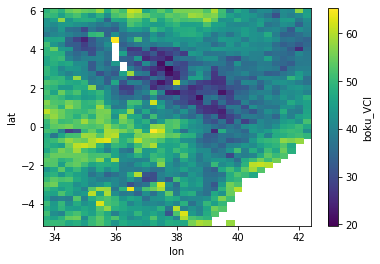

In [10]:
# Plot the MEAN VCI data (`boku_VCI`) as a map
ds['boku_VCI'].mean(dim='time').plot();

## We can easily convert to a pandas dataframe or numpy array
- Here we are going to select a 5x5 grid of the latlons, selecting the first 5 latlons (by index number = `ds.isel()`)

For numpy:
```
ds.values
```

**NOTE**: `to_dataframe()` function can be time consuming so try to select an area or one of the variables first!
For pandas:
```
ds.to_dataframe()
```

In [11]:
# convert 5x5 grid of lat lons to numpy
np_array =  ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)).values

print("shape (times, lat, lon): ", np_array.shape)

shape (times, lat, lon):  (216, 5, 5)


#### For pandas notice our multi-index
- Because our data here is 3D (lat, lon, time) we have 3 indexes in the dataframe
- we can set these as columns using the `df.reset_index()` function. 
- then we have a pretty standard csv format

In [12]:
df = ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)).to_dataframe()
df.head()

boku_VCI
time       lat lon             
2001-12-31 6.0 33.75  43.718593
               34.00  31.132075
               34.25  85.882353
               34.50  20.183486
               34.75  58.447489

# A more standard time series format

#### Let's turn each column into VCI for a given pixel (lat-lon pair)
- to do this we need to `.stack()` the lat lon dimensions to get a pixel dimension (2d -> 1d)
- this is unfortunately more involved but i guess this is kinda what you were interested in!

In [13]:
stacked = ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)).stack(pixel=['lat', 'lon'])

# store the pixel latlon (is this useful?)
pixels = stacked.pixel.values
pixel_map = {i: pxl for i, pxl in enumerate(pixels)}
column_map  = {f"VCI_{pixel_id}" for pixel_id in pixel_map.keys()}
times = [pd.to_datetime(t) for t in stacked.time.values]

stacked_df = pd.DataFrame(stacked.values, columns=[f"VCI_{pixel_id}" for pixel_id in pixel_map.keys()], index=times)
# stacked_df.to_csv(os.path.join(data_dir,'vci_pixels.csv')
stacked_df.head()

,VCI_0,VCI_1,VCI_2,VCI_3,VCI_4,VCI_5,VCI_6,VCI_7,VCI_8,VCI_9,...,VCI_15,VCI_16,VCI_17,VCI_18,VCI_19,VCI_20,VCI_21,VCI_22,VCI_23,VCI_24
2001-12-31,43.718593,31.132075,85.882353,20.183486,58.447489,63.900415,72.123894,65.695793,87.570621,61.691542,...,41.538462,94.464945,77.238806,62.857143,6.666667e+01,60.080645,58.102767,37.549407,100.000000,1.000000e+02
2002-01-31,2.843602,16.078431,33.333333,78.169014,67.796610,56.603774,45.086705,24.409449,58.723404,64.541833,...,20.105820,66.666667,33.816425,30.687831,2.695312e+01,19.004525,11.956522,0.000000,62.886598,3.098592e+01
2002-02-28,34.337349,29.411765,1.973684,56.818182,33.854167,16.842105,21.052632,30.000000,47.651007,48.514851,...,10.389610,21.354167,16.176471,1.834862,-3.552714e-15,0.000000,9.411765,0.000000,14.388489,7.105427e-15
2002-03-31,50.000000,34.065934,23.602484,44.715447,20.138889,32.203390,18.461538,24.657534,21.551724,34.722222,...,20.270270,16.935484,21.875000,5.714286,-3.552714e-15,12.244898,13.559322,0.000000,0.000000,3.194444e+01
2002-04-30,54.945055,90.322581,43.930636,73.722628,75.949367,62.857143,76.282051,47.023810,66.197183,73.964497,...,50.310559,36.521739,71.005917,39.682540,2.315271e+01,79.545455,25.490196,3.773585,1.973684,7.608696e+00


In [14]:
x_axis_labels = stacked_df.index.map(lambda x: '%s-%s-%s' % (x.year,x.month,x.day))
x_axis_labels

Index(['2001-12-31', '2002-1-31', '2002-2-28', '2002-3-31', '2002-4-30',
       '2002-5-31', '2002-6-30', '2002-7-31', '2002-8-31', '2002-9-30',
       ...
       '2019-2-28', '2019-3-31', '2019-4-30', '2019-5-31', '2019-6-30',
       '2019-7-31', '2019-8-31', '2019-9-30', '2019-10-31', '2019-11-30'],
      dtype='object', length=216)

In [15]:
def plot_series(series, cols, new_names, x_axis=None):
    df = series.copy()
    fig, ax = plt.subplots(figsize=(18, 8))
    for col, name in zip(cols, new_names):
        df.rename(columns={col: name}, inplace=True)
    df[new_names].plot(ax=ax)
    ax.set_title('VCI (Vegetation Condition Index) for two pixels')
    ax.set_xlabel('time')
    ax.set_ylabel('VCI')
    
    plt.legend(fontsize=14, loc='best')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

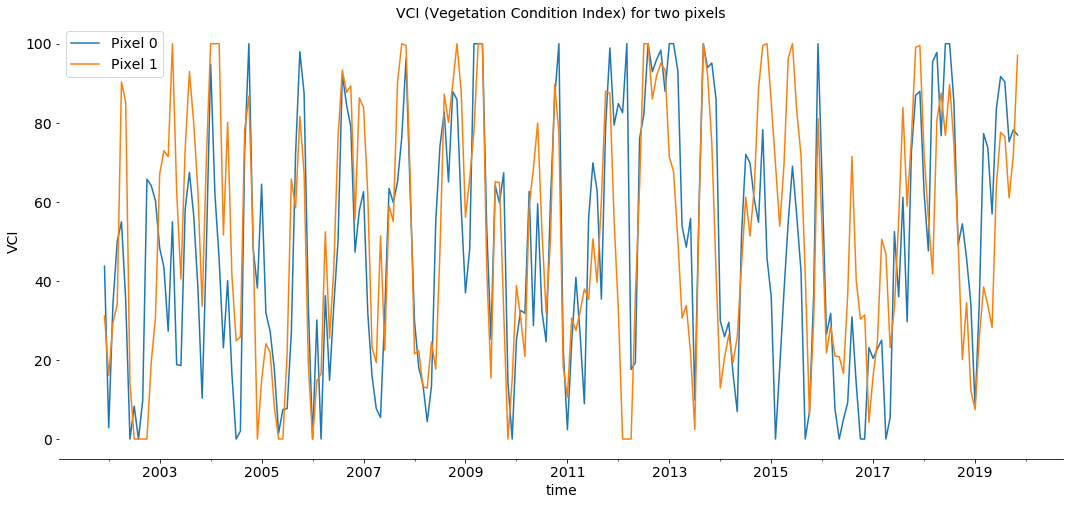

In [16]:
plot_series(stacked_df, cols=['VCI_0','VCI_1'], new_names=["Pixel 0", "Pixel 1"])

# Infer daily VCI Scores

In [17]:
import gpflow

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [18]:
print(gpflow.__version__)

1.5.1


Install the non-GPU accelerated GPFlow 1.5 via: `pip install gpflow`

## normalise the data
Decide how you want to normalise your data, max-min, or zero mean Gaussian... 

In [22]:
# scaled_df = (stacked_df['VCI_0'] - stacked_df['VCI_0'].min())/ (stacked_df['VCI_0'].max() - stacked_df['VCI_0'].min())
column_means = stacked_df.mean()
column_stds = stacked_df.std()

scaled_df = (stacked_df - column_means)/ (column_stds)
scaled_df.head()

,VCI_0,VCI_1,VCI_2,VCI_3,VCI_4,VCI_5,VCI_6,VCI_7,VCI_8,VCI_9,...,VCI_15,VCI_16,VCI_17,VCI_18,VCI_19,VCI_20,VCI_21,VCI_22,VCI_23,VCI_24
2001-12-31,-0.172666,-0.673365,1.266238,-1.184600,0.087159,0.461555,0.794567,0.648406,1.323487,0.342218,...,-0.054663,1.753494,1.103386,0.600249,0.852088,0.631062,0.617962,-0.210492,2.150104,2.084735
2002-01-31,-1.498485,-1.167785,-0.523571,0.826753,0.400313,0.212384,-0.162267,-0.665356,0.312194,0.442019,...,-0.767408,0.832242,-0.339214,-0.439813,-0.549152,-0.716858,-0.894337,-1.476692,0.890959,-0.158686
2002-02-28,-0.476955,-0.729867,-1.591674,0.086153,-0.736610,-1.145430,-1.012821,-0.487460,-0.075969,-0.119156,...,-1.090522,-0.669442,-0.925258,-1.372655,-1.500158,-1.340495,-0.977733,-1.476692,-0.754434,-1.165937
2002-03-31,0.031078,-0.577006,-0.855001,-0.333656,-1.196012,-0.620860,-1.104519,-0.657462,-0.990928,-0.602096,...,-0.761939,-0.815880,-0.735938,-1.247229,-1.500158,-0.938676,-0.841810,-1.476692,-1.242592,-0.127528
2002-04-30,0.191475,1.270680,-0.162629,0.672520,0.673395,0.425929,0.941722,0.054250,0.574201,0.771948,...,0.237054,-0.166779,0.896314,-0.149006,-0.683245,1.269803,-0.450813,-1.349444,-1.175631,-0.918603


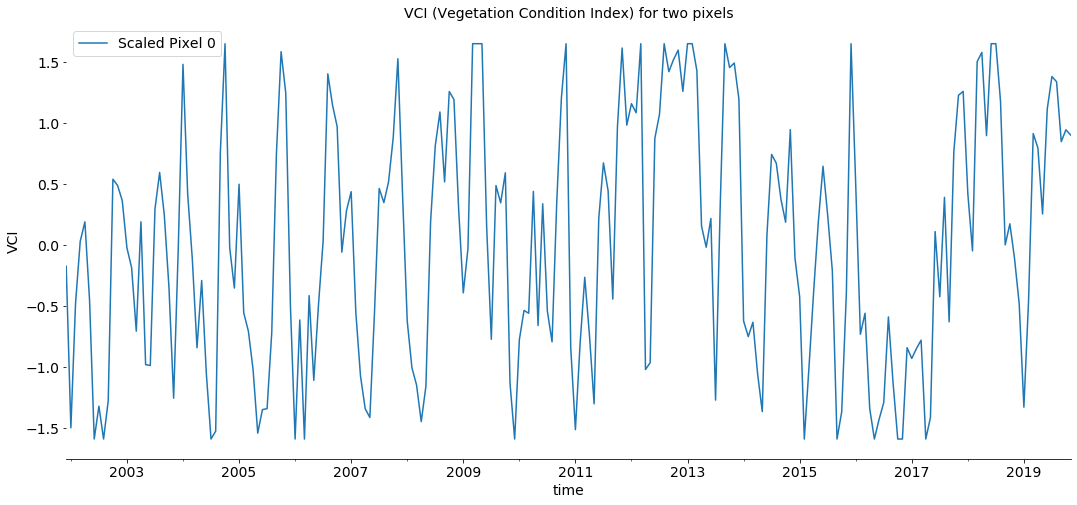

In [16]:
# Rescaled data
plot_series(scaled_df, cols=['VCI_0'], new_names=["Scaled Pixel 0"])

## Using pandas Interpolate function (no uncertainty)

In [77]:
df_frame = scaled_df.resample('D').mean()
df_frame.index = (df_frame.index - df_frame.index[0]).days

original_data = (df_frame*column_stds) + column_means

interpolated_df = df_frame.interpolate()
interpolated_df = (interpolated_df*column_stds) + column_means
interpolated_df.head()

,VCI_0,VCI_1,VCI_2,VCI_3,VCI_4,VCI_5,VCI_6,VCI_7,VCI_8,VCI_9,...,VCI_15,VCI_16,VCI_17,VCI_18,VCI_19,VCI_20,VCI_21,VCI_22,VCI_23,VCI_24
0,43.718593,31.132075,85.882353,20.183486,58.447489,63.900415,72.123894,65.695793,87.570621,61.691542,...,41.538462,94.464945,77.238806,62.857143,66.666667,60.080645,58.102767,37.549407,100.000000,100.000000
1,42.400045,30.646474,84.187223,22.053987,58.749073,63.665039,71.251726,64.363975,86.640066,61.783487,...,40.847086,93.568226,75.838084,61.819423,65.385585,58.755609,56.614178,36.338136,98.802793,97.773739
2,41.081497,30.160873,82.492094,23.924488,59.050658,63.429664,70.379559,63.032158,85.709511,61.875432,...,40.155710,92.671507,74.437362,60.781703,64.104503,57.430573,55.125590,35.126865,97.605587,95.547478
3,39.762949,29.675271,80.796964,25.794989,59.352242,63.194288,69.507392,61.700340,84.778955,61.967377,...,39.464335,91.774789,73.036640,59.743984,62.823421,56.105537,53.637001,33.915594,96.408380,93.321218
4,38.444401,29.189670,79.101834,27.665490,59.653827,62.958913,68.635224,60.368523,83.848400,62.059322,...,38.772959,90.878070,71.635918,58.706264,61.542339,54.780501,52.148413,32.704322,95.211174,91.094957


## Gaussian Process Regression

- different kernel options
- think about priors on GP hyperparameters
- different data normalisations options

In [49]:

x_train = df_frame.dropna().index.to_numpy().astype(float).reshape(-1,1)
y_train_norm = df_frame['VCI_0'].dropna().to_numpy().astype(float).reshape(-1,1)
y_train = (y_train_norm*column_stds.iloc[0])+column_means.iloc[0]
x_train.shape, y_train.shape


((216, 1), (216, 1))

In [34]:
# Here you are including the actual training points as test points - to let the GP update the potentially noisy observation in x_train
x_test = df_frame.index.to_numpy().astype(float).reshape(-1,1)
x_test.shape

(6544, 1)

In [36]:
rbf_kernel = gpflow.kernels.RBF(1, variance=0.5, lengthscales=30)
likelihood = gpflow.likelihoods.Gaussian()
model1 = gpflow.models.GPR(x_train, y_train_norm, kern=rbf_kernel)
model1.clear()

# You can play with hyperparameter priors if you like
# m.kern.lengthscales.prior = gpflow.priors.inv Gamma(1., 1.)
# m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
# m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
model1.compile()
model1.as_pandas_table()

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-072d8d47-9/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    retu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-072d8d47-9/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    retu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-072d8d47-9/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    retu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-072d8d47-9/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    retu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-1377efef-0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-1377efef-0/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-1377efef-0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*arg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-1377efef-0/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*arg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-072d8d47-9/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, *

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-072d8d47-9/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, *

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,30.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.5
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [37]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(model1)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.220386
  Number of iterations: 16
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.220386
  Number of iterations: 16
  Number of functions evaluations: 18


In [55]:

def plot_gp(mean,var, title):
    fig, ax = plt.subplots(figsize=(25, 8))
    plt.plot(x_train, y_train, 'kx', mew=1, label="data point")
    ax.plot(x_test, mean, lw=2, label="mean")
    plt.fill_between(x_test[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2, label="confidence")

    ax.set_title('GP Infered VCI (Vegetation Condition Index) for one pixel %s' %title)
    ax.set_xlabel('day')
    ax.set_ylabel('scaled VCI')

    plt.legend(fontsize=14, loc='best')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                      + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.show()

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-154c5c31-3/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwarg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-154c5c31-3/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwarg

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-9ca10721-24/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-9ca10721-24/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

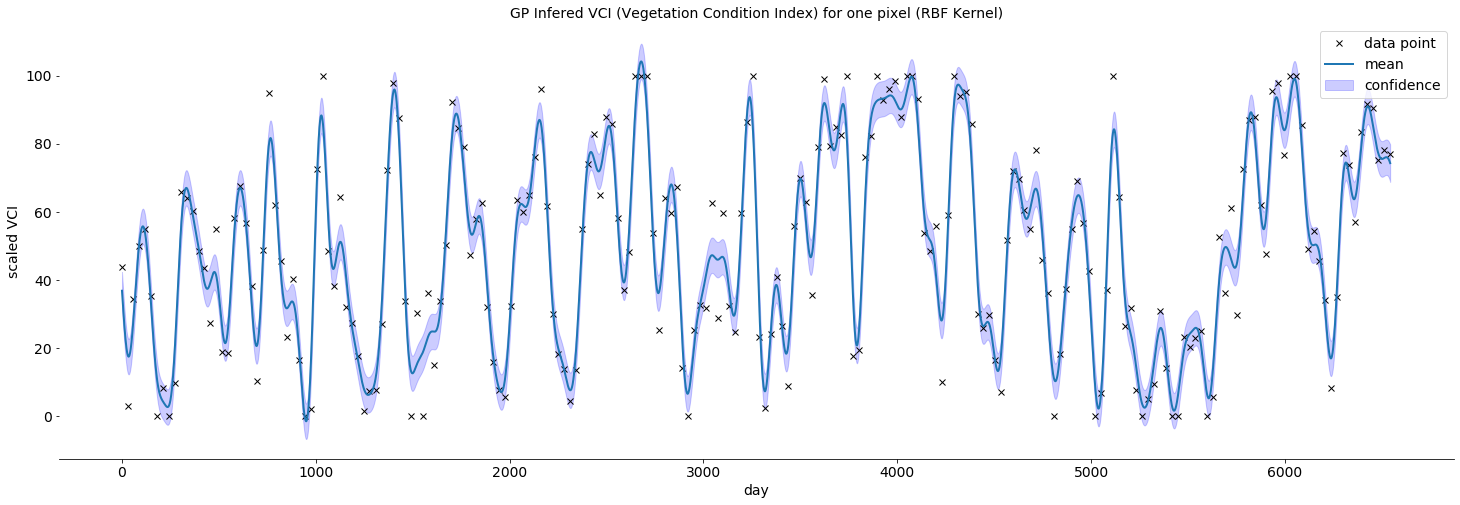

In [56]:
# Predict all test points 
(mean, var) = model1.predict_y(x_test)

# Rescale results
rescaled_mean = (mean*column_stds.iloc[0]) + column_means.iloc[0]
rescaled_var = (var*column_stds.iloc[0])

    
# Plot the GP and uncertainty bounds
plot_gp(rescaled_mean,rescaled_var, title="(RBF Kernel)")

# Or use a Mattern kernel - for less smooth dynamics


In [53]:
mattern_kernel = gpflow.kernels.Matern32(1, variance=0.5, lengthscales=30)
likelihood = gpflow.likelihoods.Gaussian()
model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)
model2.clear()

# You can play with hyperparameter priors if you like
# m.kern.lengthscales.prior = gpflow.priors.inv Gamma(1., 1.)
# m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
# m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
model2.compile()
model2.as_pandas_table()

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model2)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-94c5f2bf-42/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-94c5f2bf-42/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-94c5f2bf-42/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-94c5f2bf-42/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-50b17724-45/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-50b17724-45/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-bf2fce90-56/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    ret

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-bf2fce90-56/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    ret

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-bf2fce90-56/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    ret

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-bf2fce90-56/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/models/model.py", line 84, in _build
    self._objective = objective  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/dataholders.py", line 91, in _build
    self._is_initialized_tensor = tf.is_variable_initialized(tensor)  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    ret

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-b2f4ea73-47/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-b2f4ea73-47/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-b2f4ea73-47/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-b2f4ea73-47/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, **kwar

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-bf2fce90-56/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-bf2fce90-56/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_prior(priors)  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/home/paul/.local/lib/python3.6/site-packages/gpflow/params/parameter.py", line 373, in _build
    self._prior_tensor = prior  File "/home/paul/.local/lib/python3.6/site-packages/tensorflow_core/python/util/tf_should_use.py", line 198, in wrapped
    return _add_should_use_warning(fn(*args, 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.638872
  Number of iterations: 13
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.638872
  Number of iterations: 13
  Number of functions evaluations: 16


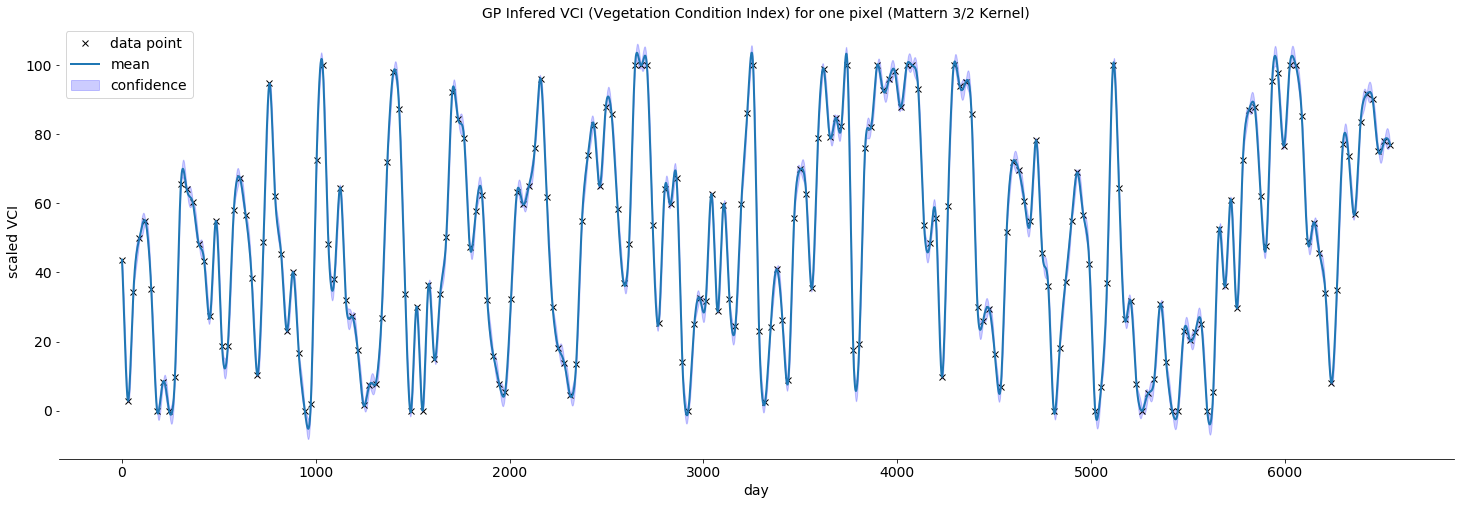

In [57]:
(mean, var) = model2.predict_y(x_test)

# Rescale results
rescaled_mat_mean = (mean*column_stds.iloc[0]) + column_means.iloc[0]
rescaled_mat_var = (var*column_stds.iloc[0])

# Plot the GP and uncertainty bounds
plot_gp(rescaled_mat_mean,rescaled_mat_var, title="(Mattern 3/2 Kernel)")

0      -0.172666
1      -0.215434
2      -0.258202
3      -0.300971
4      -0.343739
          ...   
6539    0.909400
6540    0.907969
6541    0.906538
6542    0.905106
6543    0.903675
Name: VCI_0, Length: 6544, dtype: float64

In [79]:
gp_predictions = pd.DataFrame({'Original Data': original_data.iloc[:,0],
                               'RBF_GP (mean)':rescaled_mean.reshape(-1), 
                               'RBF GP (var)':rescaled_var.reshape(-1), 
                               'Matt_GP (mean)':rescaled_mat_mean.reshape(-1), 
                               'Matt_GP (var)':rescaled_mat_var.reshape(-1), 
                               'SimpleInterpolation': interpolated_df.iloc[:,0]},
                               index=interpolated_df.index)
gp_predictions.head()

,Original Data,RBF_GP (mean),RBF GP (var),Matt_GP (mean),Matt_GP (var),SimpleInterpolation
0,43.718593,36.781327,7.566125,43.716480,0.002605,43.718593
1,NaN,35.913110,7.459554,42.483027,0.040438,42.400045
2,NaN,35.044822,7.363983,41.168927,0.144633,41.081497
3,NaN,34.178249,7.278805,39.782358,0.301443,39.762949
4,NaN,33.315202,7.203391,38.331275,0.497706,38.444401


In [80]:
gp_predictions.to_csv("Data/gp_predictions.csv")